In [8]:
import geopandas as gpd
import pandas as pd
import sys
sys.path.append('../src')
from gee import get_s2_hsv_median, get_s2_rgb_median, initialize_ee_with_credentials

initialize_ee_with_credentials()

In [16]:
v2_dataset = gpd.read_parquet("/home/christopher.x.ren/datasets/ra_tea/tile_classifier_dataset_v2_java-sumatra.parquet")

sampled_tiles = []
for class_name in v2_dataset['class'].unique():
    class_sample = v2_dataset[v2_dataset['class'] == class_name].sample(n=25, random_state=42)
    sampled_tiles.append(class_sample)

sampled_df = pd.concat(sampled_tiles)



In [41]:
import ee
import os
def compute_point_imagery(row, size=64, scale=10):
    """Compute RGB and HSV imagery for a single point.
    
    Args:
        row: GeoDataFrame row with point geometry
        size: Output image size in pixels
        scale: Pixel scale in meters
        
    Returns:
        Dictionary with RGB and HSV arrays for the point
    """
    initialize_ee_with_credentials()
    point = ee.Geometry.Point([row.geometry.x, row.geometry.y])
    
    # Get the RGB and HSV composites
    rgb_image = get_s2_rgb_median(point)
    hsv_image = get_s2_hsv_median(point)
    
    # Calculate bounds centered on point
    half_width = (size * scale) / 2
    bounds = point.buffer(half_width).bounds()
    
    # Get coordinates for the request
    coords = bounds.coordinates().get(0).getInfo()
    min_x = coords[0][0]
    min_y = coords[0][1]
    
    # Common grid parameters
    grid = {
        'dimensions': {'width': size, 'height': size},
        'affineTransform': {
            'scaleX': (coords[2][0] - coords[0][0]) / size,
            'shearX': 0,
            'translateX': min_x,
            'shearY': 0,
            'scaleY': (coords[2][1] - coords[0][1]) / size,
            'translateY': min_y
        },
        'crsCode': 'EPSG:4326'
    }
    
    # Get RGB data
    rgb_request = {
        'expression': rgb_image,
        'fileFormat': 'NUMPY_NDARRAY',
        'grid': grid,
        'bandIds': ['B4', 'B3', 'B2']
    }
    
    # Get HSV data
    hsv_request = {
        'expression': hsv_image,
        'fileFormat': 'NUMPY_NDARRAY',
        'grid': grid,
        'bandIds': ['hue', 'saturation', 'value']
    }
    
    try:
        rgb_data = ee.data.computePixels(rgb_request)
        hsv_data = ee.data.computePixels(hsv_request)
        
        return {
            'tile_id': row.tile_id,
            'rgb': rgb_data,
            'hsv': hsv_data,
            'class': row['class']
        }
    except Exception as e:
        print(f"Error processing tile {row.tile_id}: {e}")
        return None


def get_point_imagery_parallel(point_df, n_jobs=-1):
    """Get RGB and HSV imagery for points in parallel.
    
    Args:
        point_df: GeoDataFrame with point geometries
        n_jobs: Number of parallel jobs (-1 for all cores)
        
    Returns:
        Dictionary with RGB and HSV arrays for each point
    """
    from joblib import Parallel, delayed

    # Process points in parallel
    results = Parallel(n_jobs=n_jobs, verbose=20)(
        delayed(compute_point_imagery)(row) 
        for _, row in point_df.iterrows()
    )
    
    # Convert list of results to dictionary, filtering out None values
    return {
        r['tile_id']: r 
        for r in results 
        if r is not None
    }


# # Get imagery for sampled points in parallel
# results = get_point_imagery_parallel(sampled_df)
result = compute_point_imagery(sampled_df.iloc[0], size=32)


In [48]:
water_df = sampled_df[sampled_df['class'] == 'sumatra_crops']
water_results = get_point_imagery_parallel(water_df)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    4.8s remaining:   54.6s
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:    5.1s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:    5.5s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    6.0s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:    6.3s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:    6.7s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    6.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    7.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    7.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapse

In [50]:
sampled_df['class'].unique()

array(['ei_neg', 'java_water', 'java_trees', 'java_crops',
       'java_rangeland', 'sumatra_water', 'sumatra_trees',
       'sumatra_crops', 'sumatra_rangeland', 'ei_pos'], dtype=object)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapse

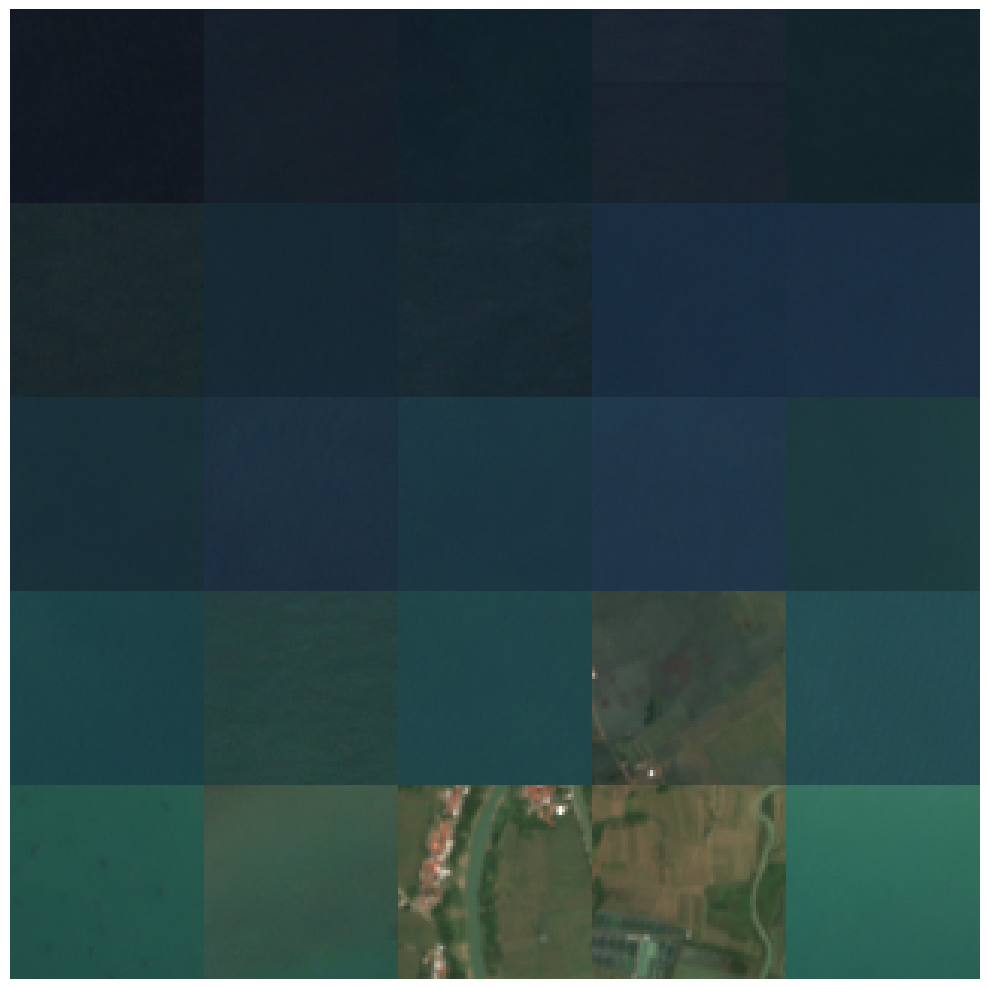

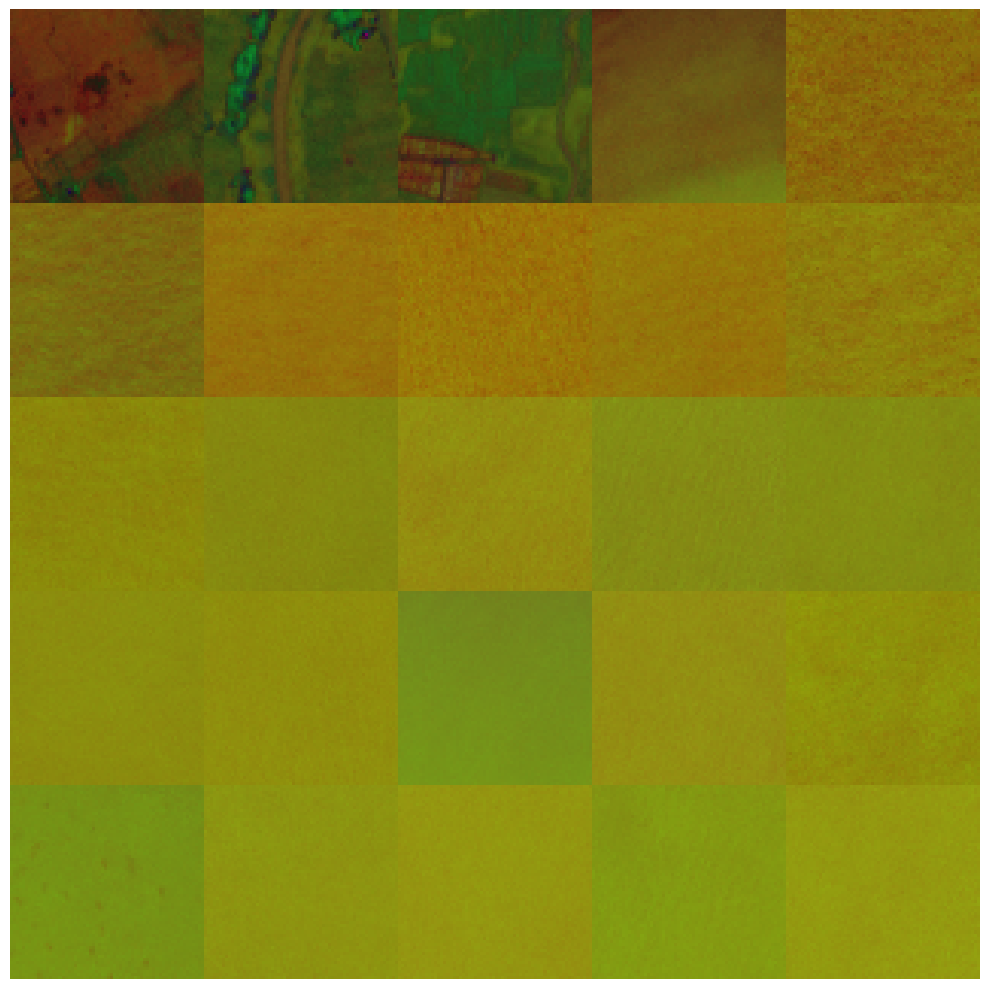

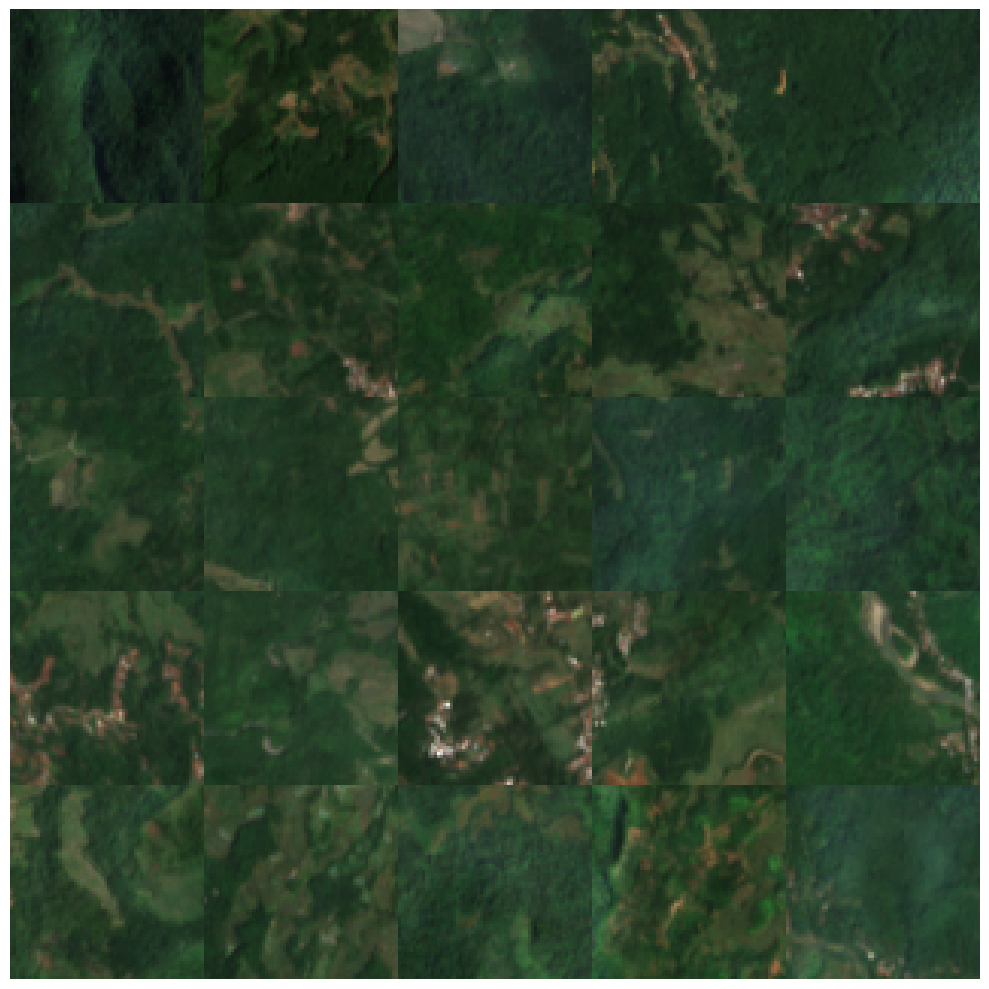

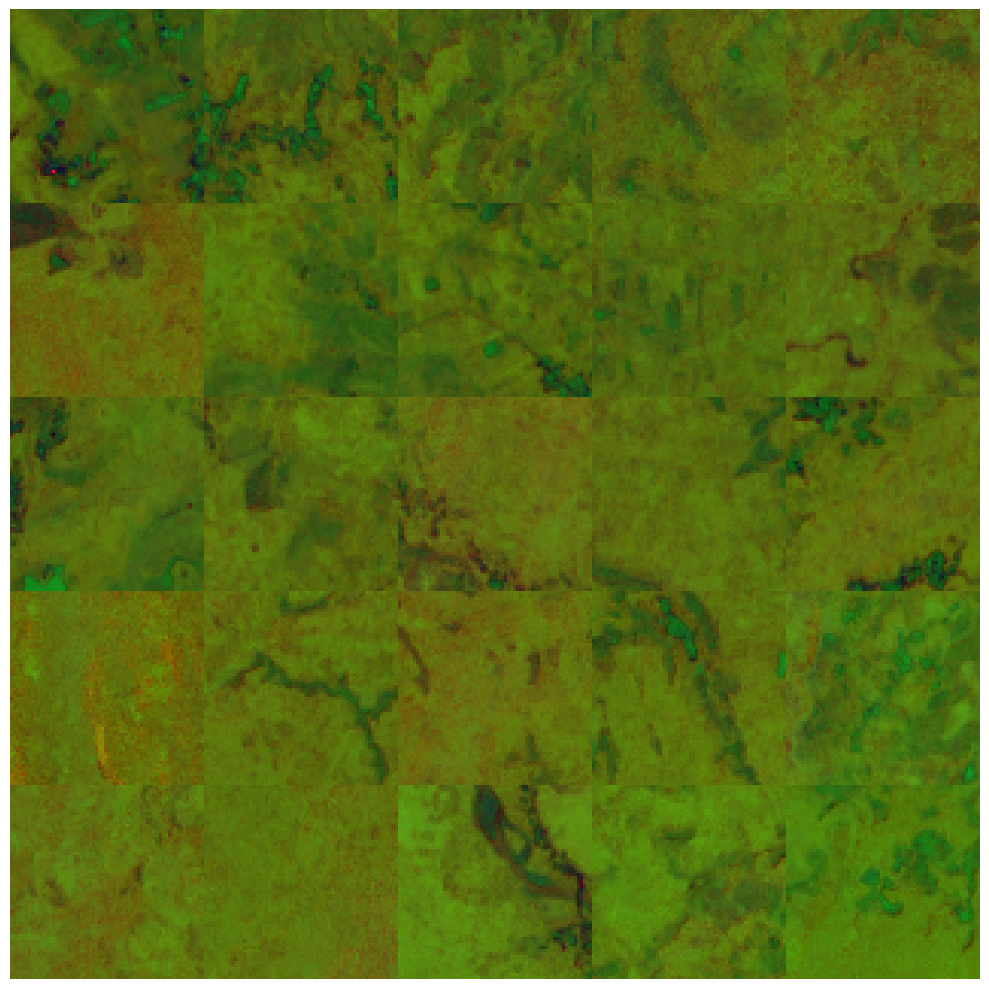

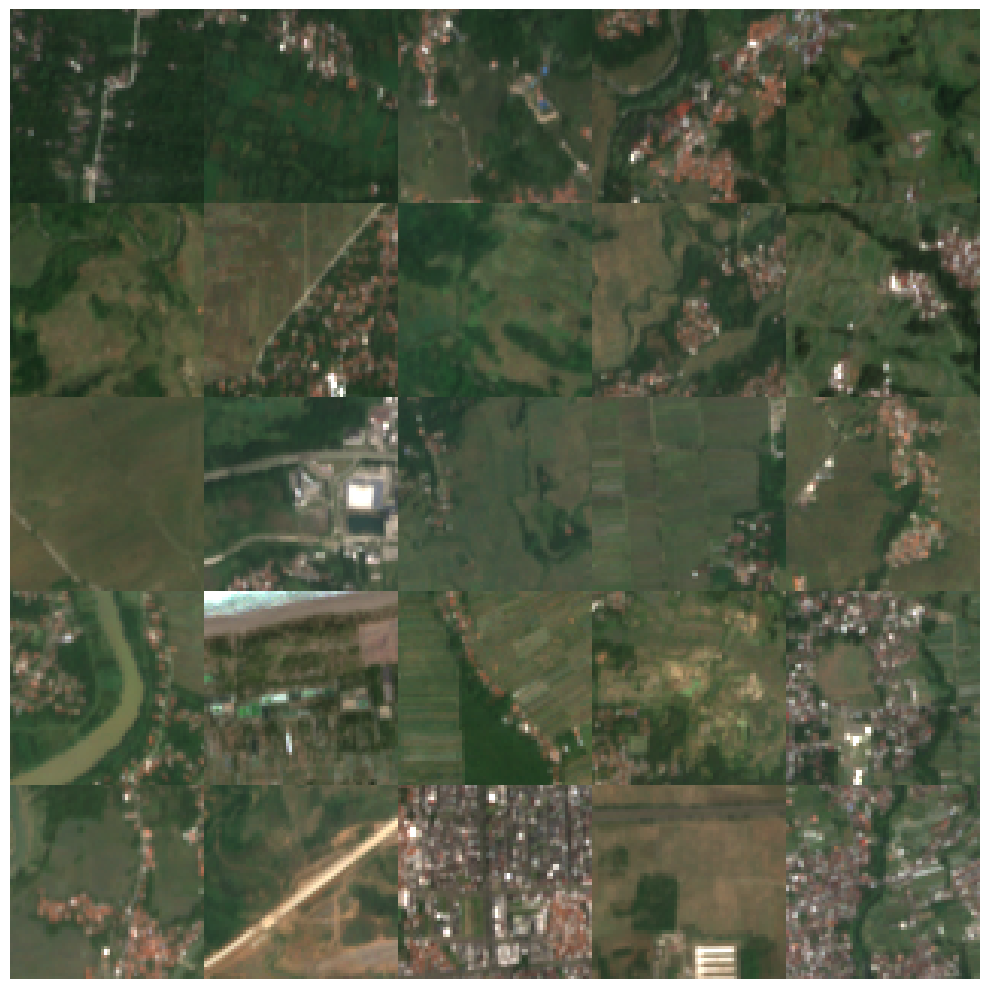

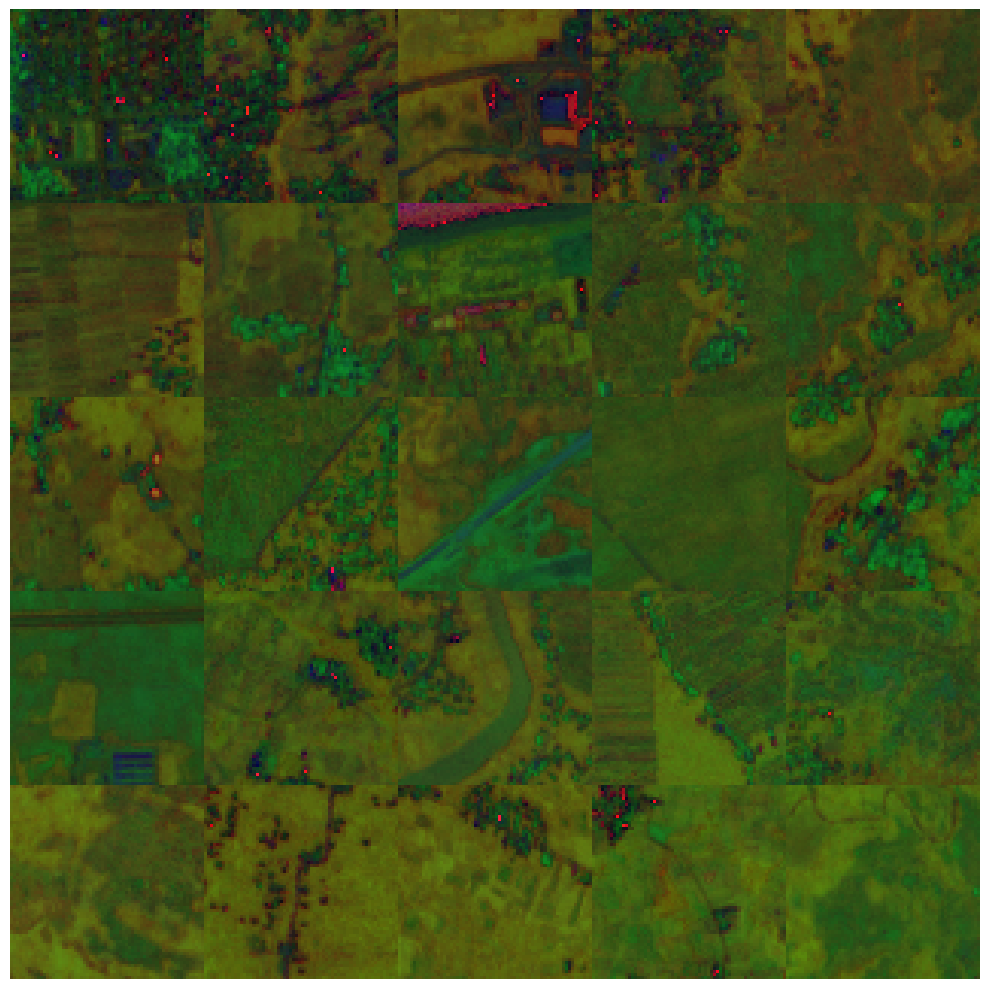

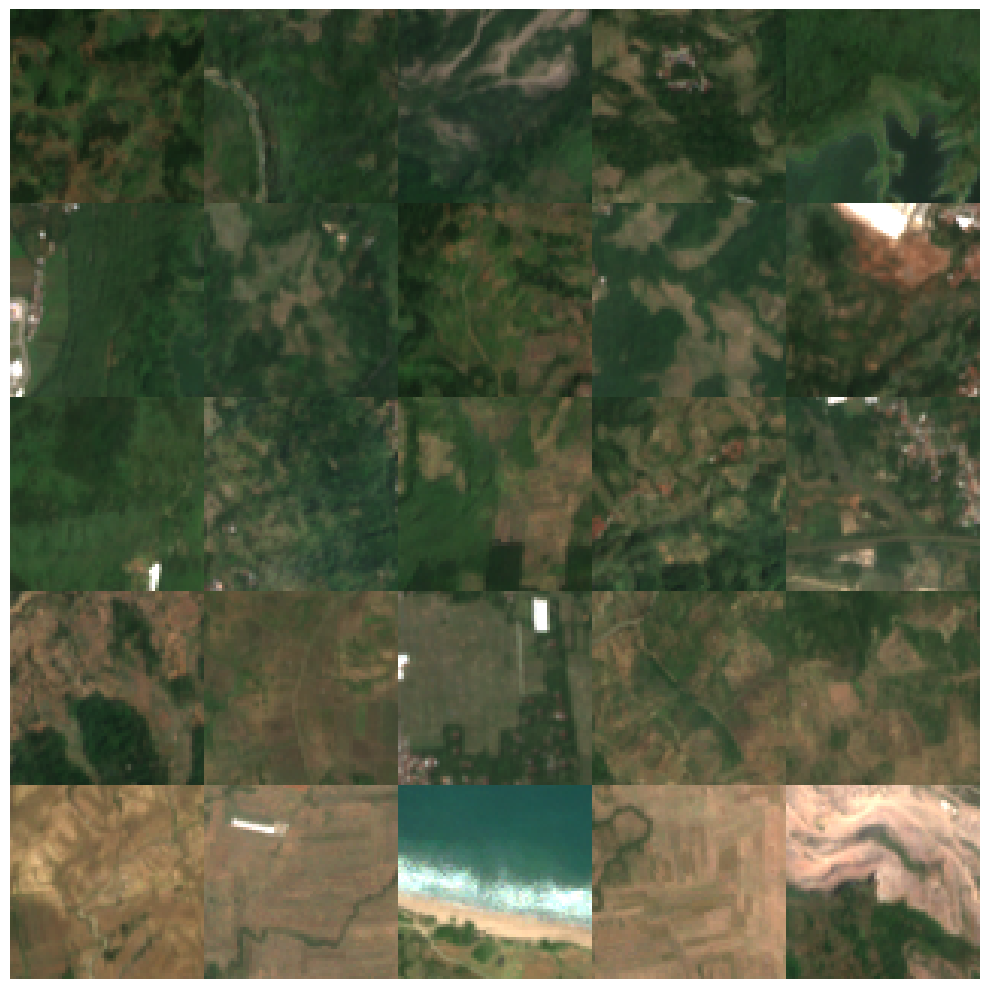

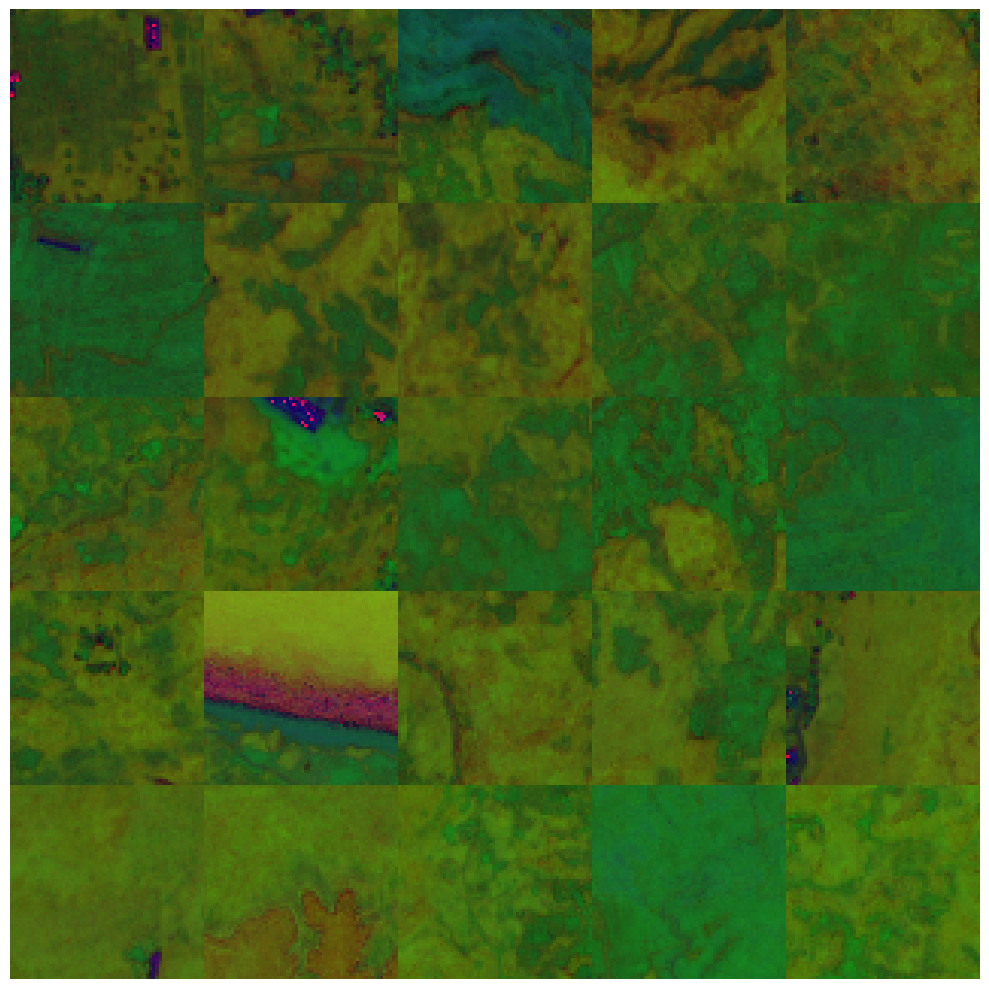

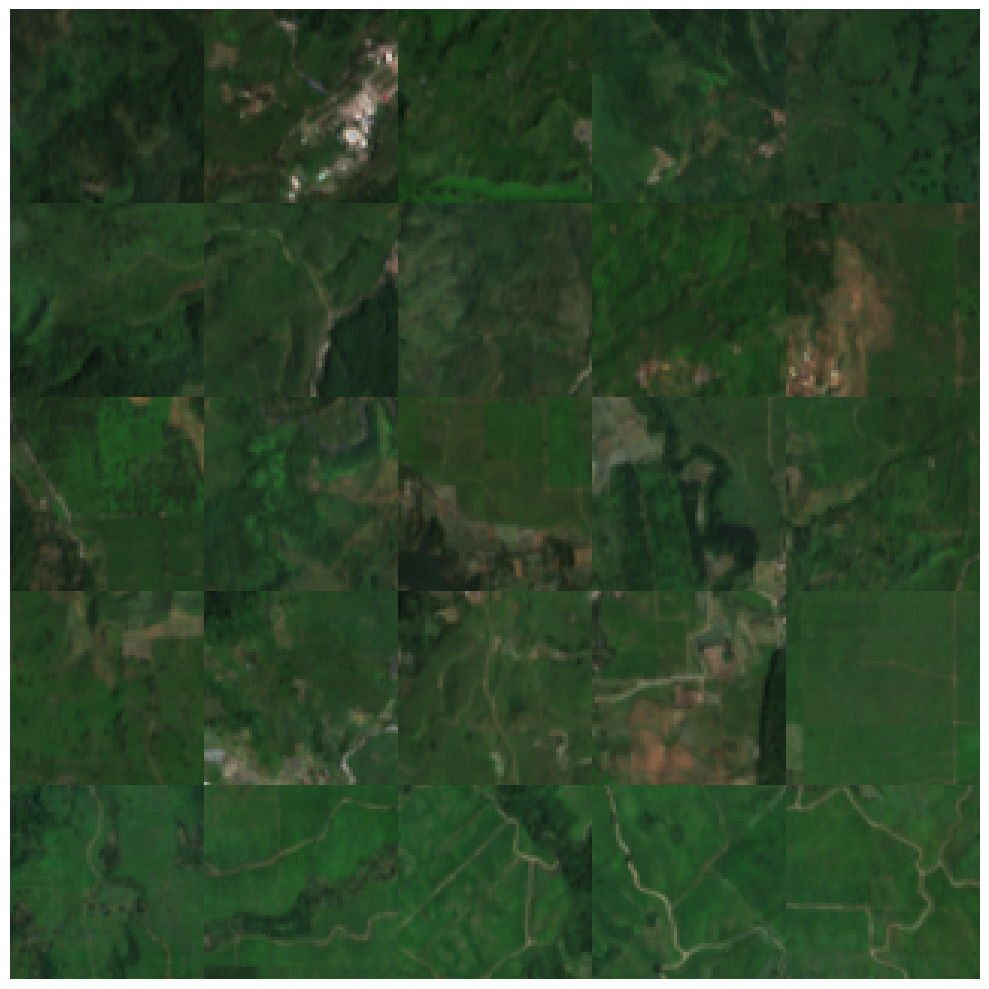

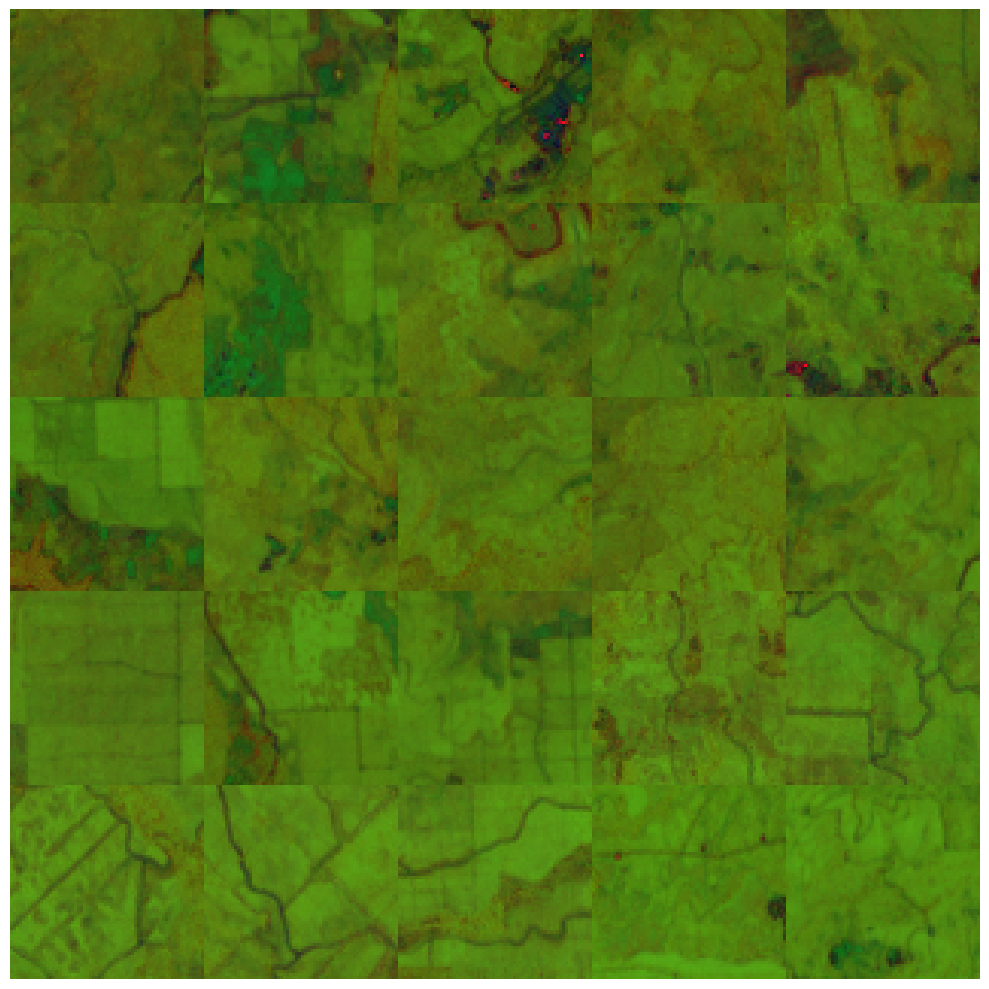

In [51]:
import numpy as np

def plot_class_imagery(class_name, output_dir):
    """Plot and save RGB and HSV image grids for a given class.
    
    Args:
        class_name: Name of class to plot
        output_dir: Directory to save output images
    """
    class_df = sampled_df[sampled_df['class'] == class_name]
    class_results = get_point_imagery_parallel(class_df)

    rgb_plots = []
    hsv_plots = []
    for tile_id, result in class_results.items():
        rgb = np.dstack([result['rgb']['B4'], result['rgb']['B3'], result['rgb']['B2']])
        hsv = np.dstack([result['hsv']['hue'], result['hsv']['saturation'], result['hsv']['value']])
        
        green_median = np.median(result['rgb']['B3'])
        sat_median = np.median(result['hsv']['saturation'])
        
        rgb_plots.append((green_median, rgb))
        hsv_plots.append((sat_median, hsv))

    rgb_plots.sort(key=lambda x: x[0])
    hsv_plots.sort(key=lambda x: x[0])

    plt.figure(figsize=(10, 10))
    grid_rgb = np.vstack([np.hstack([rgb/2500 for _, rgb in rgb_plots[i:i+5]]) 
                         for i in range(0, min(25, len(rgb_plots)), 5)])
    plt.imshow(grid_rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{class_name}_rgb.png')


    plt.figure(figsize=(10, 10))
    grid_hsv = np.vstack([np.hstack([hsv for _, hsv in hsv_plots[i:i+5]]) 
                         for i in range(0, min(25, len(hsv_plots)), 5)])
    plt.imshow(grid_hsv)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{class_name}_hsv.png')

for class_name in ['java_water', 'java_trees', 'java_crops',
       'java_rangeland', 'ei_pos']:
    plot_class_imagery(class_name, '../figures/classifier_samples')